# Digital content management
### Create a classifier that predicts multiple features of the author of a given text

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

In [2]:
dataset = pd.read_csv('Dataset - blogtext.csv')
dataset.sample(5)

,id,gender,age,topic,sign,date,text
364882,1912582,female,46,indUnk,Virgo,"23,July,2004",urlLink QuitNet certificate for 3 days ...
367684,3344979,male,36,Communications-Media,Aries,"19,May,2004",urlLink The view from lovely do...
337390,3970345,male,25,indUnk,Gemini,"14,July,2004",I saw a row or ducks crossing a 6 lane ...
394923,3902696,female,25,Student,Virgo,"11,July,2004","When I first knew you, I didn’t k..."
191180,3532480,male,36,InvestmentBanking,Aquarius,"09,June,2004","Today, I will try to explain why ..."


In [3]:
dataset.shape

(681284, 7)

#### Observations:
1. There are 7 columns present in the dataset.
2. 'gender', 'age', 'topic' and 'sign' are the target columns.
3. 'id' and 'date' are not relevant hence will be dropping these columns.

In [4]:
dataset.drop(['id', 'date'], axis=1, inplace=True)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681284 entries, 0 to 681283
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   gender  681284 non-null  object
 1   age     681284 non-null  int64 
 2   topic   681284 non-null  object
 3   sign    681284 non-null  object
 4   text    681284 non-null  object
dtypes: int64(1), object(4)
memory usage: 26.0+ MB


In [6]:
dataset.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,681284,2,male,345193,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,681284.0,NaN,NaN,NaN,23.932326,7.786009,13.0,17.0,24.0,26.0,48.0
topic,681284,40,indUnk,251015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sign,681284,12,Cancer,65048,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text,681284,611652,urlLink,445,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Checking for null or empty values

In [7]:
dataset.isna().sum()

gender    0
age       0
topic     0
sign      0
text      0
dtype: int64

In [8]:
dataset.isnull().sum()

gender    0
age       0
topic     0
sign      0
text      0
dtype: int64

In [9]:
dataset[dataset['text'].str.strip() == '']

,gender,age,topic,sign,text
716,male,15,Science,Libra,
3277,male,35,Technology,Aries,
3469,male,35,Technology,Aries,
3578,male,35,Technology,Aries,
3626,male,35,Technology,Aries,
...,...,...,...,...,...
679961,male,23,indUnk,Cancer,
680587,male,26,indUnk,Virgo,
680777,female,15,indUnk,Aquarius,
680802,female,15,indUnk,Aquarius,


#### Observations:
1. There are no null values present but there are empty values present in the 'text' column.
2. We will br dropping off the records with empty values in 'text' column.

In [10]:
dataset.drop(dataset[dataset['text'].str.strip() == ''].index, axis=0, inplace=True)

In [11]:
dataset.shape

(678165, 5)

### Checking for duplicate records

In [12]:
dataset.duplicated().sum()

6379

#### Observations:
1. There are around 6k duplicate records. We will drop these records.
2. Each blog is written by a single user hence we will check duplicate values based on 'text' column as well and if any duplicate records found, we will drop those records.

In [13]:
dataset.duplicated(subset='text').sum()

66565

#### Observations:
1. Based on the 'text' column, there are more 65k columns having duplicate values hence we will drop the first records to avoid the conflict for classification model.

In [14]:
dataset.drop_duplicates(subset='text', inplace=True)

In [15]:
dataset.shape

(611600, 5)

### Gender Distribution

In [16]:
dataset['gender'].value_counts()

female    307328
male      304272
Name: gender, dtype: int64

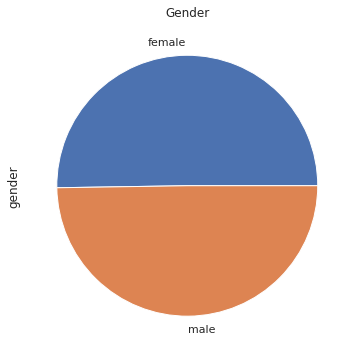

In [17]:
ax = dataset['gender'].value_counts().plot(kind='pie', figsize=(16, 6), title="Gender")
plt.show()

### Topics Distribution

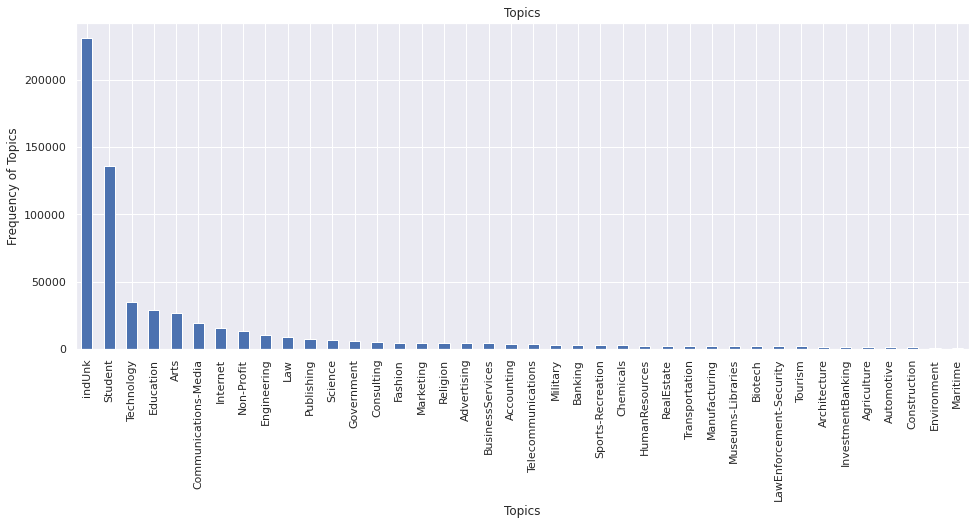

In [18]:
ax = dataset['topic'].value_counts().plot(kind='bar', figsize=(16, 6), title="Topics")
ax.set_xlabel("Topics")
ax.set_ylabel("Frequency of Topics")
plt.show()

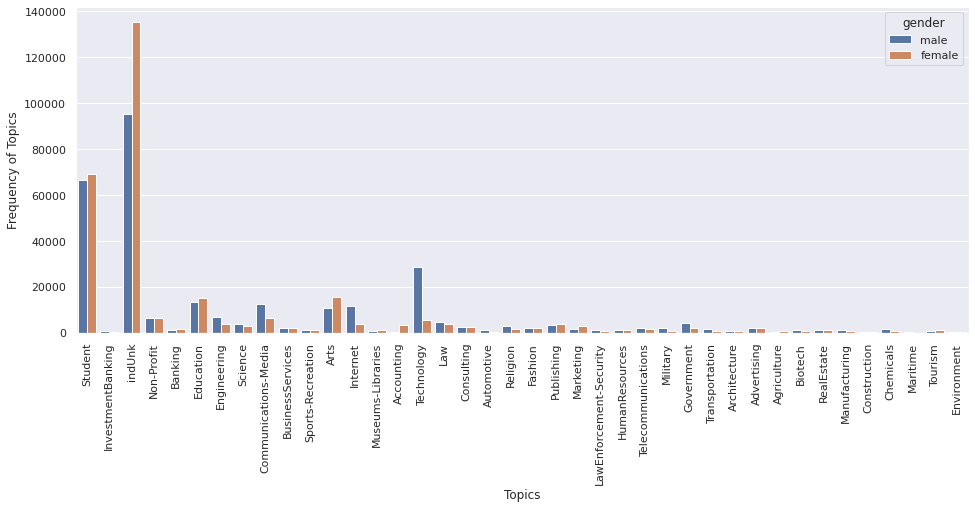

In [19]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x='topic', data=dataset, hue='gender')
ax.set_xlabel("Topics")
ax.set_ylabel("Frequency of Topics")
plt.xticks(rotation=90)
plt.show()

### Age Distribution

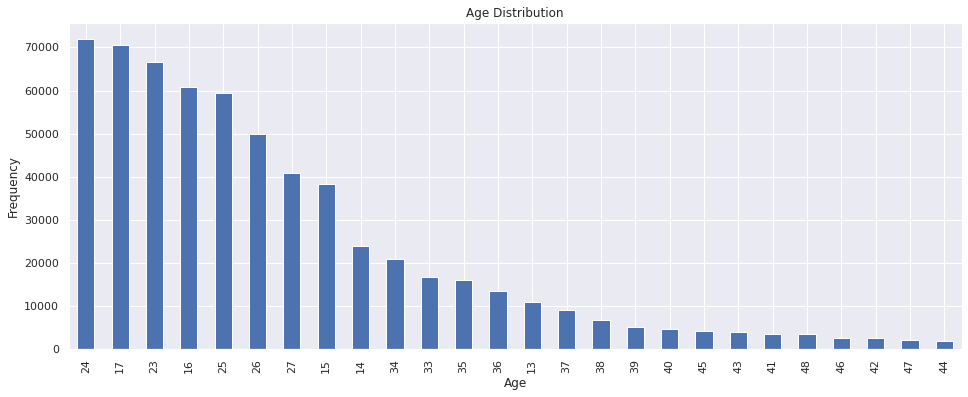

In [20]:
ax = dataset['age'].value_counts().plot(kind='bar', figsize=(16, 6), title="Age Distribution")
ax.set_xlabel("Age")
ax.set_ylabel("Frequency")
plt.show()

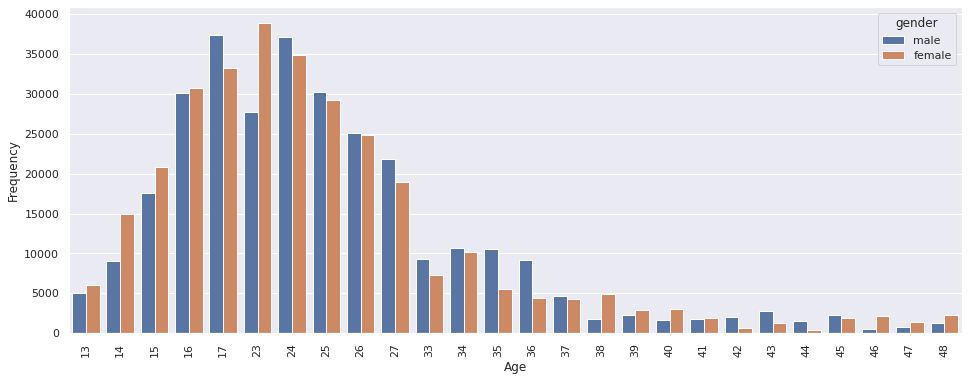

In [21]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x='age', data=dataset, hue='gender')
ax.set_xlabel("Age")
ax.set_ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

### Sign Distribution

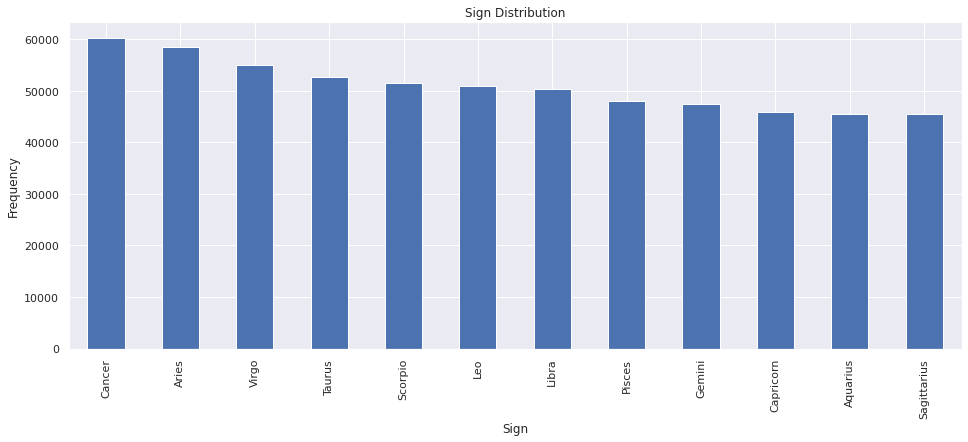

In [22]:
ax = dataset['sign'].value_counts().plot(kind='bar', figsize=(16, 6), title="Sign Distribution")
ax.set_xlabel("Sign")
ax.set_ylabel("Frequency")
plt.show()

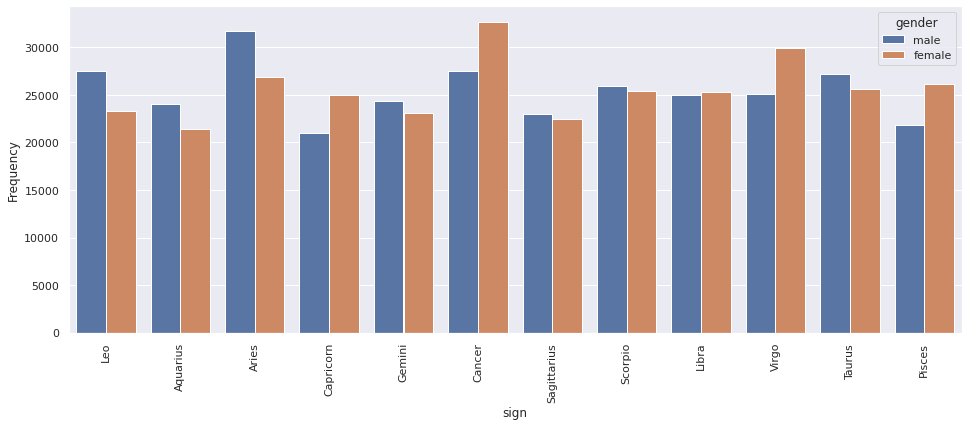

In [23]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x='sign', data=dataset, hue='gender')
ax.set_xlabel("sign")
ax.set_ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

### Data Pre-processing

In [24]:
# Lowercase 
dataset["text"] = dataset["text"].astype(str)
dataset['text'] = dataset['text'].str.lower()

In [25]:
# Removing punctuation marks
import string

PUNCT_TO_REMOVE = string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

dataset["text"] = dataset["text"].apply(lambda text: remove_punctuation(text))

In [26]:
# Removing invalid characters
dataset['text'] = dataset['text'].str.replace('[^\w\s]', '')
dataset.sample(2)

,gender,age,topic,sign,text
59114,male,26,Government,Taurus,here i am a quarterly past 200 hours t...
32410,male,41,Education,Gemini,a couple of thoughts the kerry bounceb...


In [27]:
# Removing Stopwords
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

dataset['text'] = dataset['text'].apply(lambda x: ' '.join(item for item in x.split() if item not in stop_words))

In [28]:
dataset.sample(2)

,gender,age,topic,sign,text
372132,male,14,Student,Sagittarius,well ive come back 5day school trip france ben...
411145,female,16,Student,Scorpio,hes told many times hates yet always greets sm...


In [29]:
# Stemming Sentences
from nltk.stem.porter import *
stemmer = PorterStemmer()

def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

dataset['stemmed'] = dataset['text'].apply(stem_sentences)

In [30]:
dataset.sample(5)

,gender,age,topic,sign,text,stemmed
358267,female,24,indUnk,Taurus,wow bus anymore wasbeginning think stuck dream...,wow bu anymor wasbegin think stuck dream allis...
247093,male,24,Technology,Sagittarius,currently read article magazine online hackers...,current read articl magazin onlin hacker make ...
97968,female,23,Education,Scorpio,totem animal oh crane anything beautiful slend...,totem anim oh crane anyth beauti slender bodi ...
183120,male,24,Education,Leo,went seattle jayna present fun adventure max s...,went seattl jayna present fun adventur max sca...
378520,female,24,indUnk,Libra,learned school night nbsp war diplomacy means ...,learn school night nbsp war diplomaci mean obs...


### Train test split

The dataset is huge and the system keeps getting crash hence taking a sample of the dataset to fine tune the parameters of Vectorizer. Once the best parameters can be obtained, the same will be used on the whole dataset.

In [31]:
sample_data = dataset[:20000]

In [32]:
X = sample_data['stemmed']
y = sample_data.apply(lambda col: [col['gender'], str(col['age']), col['topic'], col['sign']], axis=1)

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
print(X_train.shape)
print(X_test.shape)

(16000,)
(4000,)


#### Observations:
In this dataset, there are multiple labels are present. The algorithms are developed for sngle-label classifiation problems. Hence it is required to convert multiple label into the single label. For this, MultiLabelBinerazier will be used which transform the multi-label problem into multiple single-label problems, so that the existing single label algorithms can be used and marked the output columns in binary format.

In [35]:
label_counts = dict()

for labels in y.values:
    for label in labels:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

In [36]:
from sklearn.preprocessing import MultiLabelBinarizer
binarizer = MultiLabelBinarizer(classes=sorted(label_counts.keys()))

In [37]:
y_train_binary = binarizer.fit_transform(y_train)
y_test_binary = binarizer.transform(y_test)

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [39]:
#Optimizing parameters on baseline model
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(LogisticRegression())),
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2))
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=parameters, n_jobs=-1, verbose=1, cv=3)
grid_search.fit(X_train, y_train_binary)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        OneVsRestClassifier(estimator=LogisticRegression()))]),
             n_jobs=-1,
             param_grid={'vect__max_df': (0.5, 0.75, 1.0),
                         'vect__max_features': (None, 5000, 10000, 50000),
                         'vect__ngram_range': ((1, 1), (1, 2))},
             verbose=1)

In [40]:
print('Best Params:', grid_search.best_params_)
print('Best Score:', grid_search.best_score_)

Best Params: {'vect__max_df': 0.5, 'vect__max_features': 5000, 'vect__ngram_range': (1, 2)}
Best Score: 0.06281260595285143


In [87]:
vectorizer = CountVectorizer(ngram_range=(1, 2), max_df=0.5, max_features=5000)
transformer = TfidfTransformer()

X_train_dtm = vectorizer.fit_transform(X_train)
X_train_dtm = transformer.fit_transform(X_train_dtm)

X_test_dtm = vectorizer.transform(X_test)
X_test_dtm = transformer.transform(X_test_dtm)

In [42]:
print('Sample Training Dataset:', X_train_dtm.shape)
print('Sample Testing Dataset:', X_test_dtm.shape)

Sample Training Dataset: (16000, 5000)
Sample Testing Dataset: (4000, 5000)


In [43]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_predict

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [57]:
def find_best_model(X_train, y_train, X_test, y_test):
    models = []

    models.append(('LR', LogisticRegression()))
    models.append(('SGD', SGDClassifier()))
    models.append(('KNN', KNeighborsClassifier(n_neighbors=11)))
    models.append(('DT', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('NB', MultinomialNB()))
    models.append(('XGB', XGBClassifier(eval_metric='auc')))

    accuracy_scores = list()
    precision_scores = list()
    recall_scores = list()
    f1_scores = list()
    names = list()

    for name, model in models:
        classifier = OneVsRestClassifier(model)
        classifier.fit(X_train, y_train)
        predicted = classifier.predict(X_test)
        
        accuracy = accuracy_score(y_test, predicted)
        precision = precision_score(y_test, predicted, average='micro')
        recall = recall_score(y_test, predicted, average='micro')
        f1 = f1_score(y_test, predicted, average='micro')
        
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        
        names.append(name)
        msg = "%s : %f (%f, %f, %f)" % (name, accuracy, precision, recall, f1)
        print(msg)
        
    return names, accuracy_scores, precision_scores, recall_scores, f1_scores 

In [58]:
names, accuracy_scores, precision_scores, recall_scores, f1_scores = find_best_model(X_train_dtm, y_train_binary, X_test_dtm, y_test_binary)

LR : 0.082000 (0.777554, 0.313937, 0.447284)
SGD : 0.118750 (0.792600, 0.329375, 0.465363)
KNN : 0.013250 (0.434409, 0.170750, 0.245143)
DT : 0.049000 (0.446845, 0.412438, 0.428952)
RF : 0.116250 (0.766813, 0.315688, 0.447248)
NB : 0.032500 (0.744649, 0.252250, 0.376844)
XGB : 0.150750 (0.778073, 0.365500, 0.497363)


In [60]:
results = pd.DataFrame({'Algorithm': names, 'Accuracy': accuracy_scores, 'Precision': precision_scores, 'Recall': recall_scores, 'F1': f1_scores})
results

,Algorithm,Accuracy,Precision,Recall,F1
0,LR,0.08200,0.777554,0.313937,0.447284
1,SGD,0.11875,0.792600,0.329375,0.465363
2,KNN,0.01325,0.434409,0.170750,0.245143
3,DT,0.04900,0.446845,0.412438,0.428952
4,RF,0.11625,0.766813,0.315688,0.447248
5,NB,0.03250,0.744649,0.252250,0.376844
6,XGB,0.15075,0.778073,0.365500,0.497363


#### Observations:
1. Accuracy returns an overall measure of how much the model is correctly predicting on the entire set of data. The basic element of the metric are the single individuals in the dataset: each unit has the same weight and they contribute equally to the Accuracy value.
2. Therefore, Accuracy is most suited when we just care about single individuals instead of multiple classes.
3. Precision expresses the proportion of units our model says are Positive and they actually Positive. In other words, Precision tells us how much we can trust the model when it predicts an individual as Positive. While the Recall measures the model’s predictive accuracy for the positive class: intuitively, it measures the ability of the model to find all the Positive units in the dataset.
4. Hence for this problem, we will consider the Precision metrics for evaluation.
5. Based on the precision, SGDClassifier is performing the best and having the highest precision score.
___

In [132]:
estimator = SGDClassifier()
model = OneVsRestClassifier(estimator)
model.fit(X_train_dtm, y_train_binary)
predicted = model.predict(X_test_dtm)

print('Accuracy:', accuracy_score(y_test_binary, predicted))
print('Precision Score:', precision_score(y_test_binary, predicted, average='micro'))
print('Recall Score:', recall_score(y_test_binary, predicted, average='micro'))
print('F1 Score:', f1_score(y_test_binary, predicted, average='micro'))

Accuracy: 0.11875
Precision Score: 0.7923250564334086
Recall Score: 0.3290625
F1 Score: 0.4650033119894016


### Tuning of SGDClassifier

In [139]:
from sklearn.model_selection import GridSearchCV

classifier = OneVsRestClassifier(SGDClassifier(loss='hinge'))

parameters = {
    'estimator__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
    'estimator__loss': ['hinge', 'squared_hinge', 'modified_huber'],
    'estimator__n_jobs': [-1]
}

grid_search = GridSearchCV(estimator=classifier, param_grid=parameters, n_jobs=-1, verbose=1, cv=3)
grid_search.fit(X_train_dtm, y_train_binary)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=OneVsRestClassifier(estimator=SGDClassifier()),
             n_jobs=-1,
             param_grid={'estimator__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0,
                                              10.0, 100.0, 1000.0],
                         'estimator__loss': ['hinge', 'squared_hinge',
                                             'modified_huber'],
                         'estimator__n_jobs': [-1]},
             verbose=1)

In [141]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'estimator__alpha': 0.0001, 'estimator__loss': 'modified_huber', 'estimator__n_jobs': -1}
0.1446252276781547


In [142]:
estimator = SGDClassifier(loss='modified_huber', alpha=0.0001)
model = OneVsRestClassifier(estimator)
model.fit(X_train_dtm, y_train_binary)
predicted = model.predict(X_test_dtm)

print('Accuracy:', accuracy_score(y_test_binary, predicted))
print('Precision Score:', precision_score(y_test_binary, predicted, average='micro'))
print('Recall Score:', recall_score(y_test_binary, predicted, average='micro'))
print('F1 Score:', f1_score(y_test_binary, predicted, average='micro'))

Accuracy: 0.1645
Precision Score: 0.7393009186645754
Recall Score: 0.4124375
F1 Score: 0.5294872823557731


In [146]:
from sklearn.metrics import classification_report
print(classification_report(y_test_binary, predicted))

              precision    recall  f1-score   support

           0       0.50      0.08      0.14        24
           1       0.80      0.30      0.43       145
           2       0.65      0.18      0.28       210
           3       0.84      0.19      0.31       271
           4       0.64      0.23      0.34       403
           5       0.68      0.19      0.29       381
           6       0.84      0.31      0.45       306
           7       0.74      0.10      0.18       220
           8       0.76      0.11      0.19       202
           9       0.70      0.33      0.45       459
          10       0.83      0.19      0.31       158
          11       0.97      0.54      0.70       178
          12       0.73      0.35      0.48       508
          13       0.95      0.49      0.65       349
          14       1.00      0.14      0.25        21
          15       0.00      0.00      0.00        22
          16       0.00      0.00      0.00        21
          17       0.00    

#### Observations:
1. The dataset is highly imbalanced. As we can see, the support value in the test dataset for few classes are 0 and while the remaining having very high support values.
2. The precision score for lot of calsses are decent but for few we can observe that its less.
3. Similarly, the recall score where the support is high, the recall score is as well high but the classes where support is low, the recall is low as well.
4. Weighted F1 score is 49% which is calculated for each class. Overall the model may perform good in production environment. 
5. We will try training the model on the full dataset with the optimized parameters and evaluate the model. 

### Top 10 Entries for the actual and predicted 

In [150]:
for i in range(10):
    print('Actual:', binarizer.inverse_transform(y_test_binary)[i])
    print('Predicted:', binarizer.inverse_transform(predicted)[i], '\n')

Actual: ('23', 'Arts', 'Capricorn', 'female')
Predicted: ('23', 'Arts', 'Capricorn', 'female') 

Actual: ('35', 'Aries', 'Technology', 'male')
Predicted: ('male',) 

Actual: ('27', 'Pisces', 'Technology', 'male')
Predicted: ('male',) 

Actual: ('15', 'Libra', 'Student', 'female')
Predicted: ('15', 'Student', 'female') 

Actual: ('23', 'Pisces', 'indUnk', 'male')
Predicted: ('indUnk', 'male') 

Actual: ('24', 'Aries', 'female', 'indUnk')
Predicted: ('24', 'Aries', 'female', 'indUnk') 

Actual: ('17', 'Cancer', 'Student', 'male')
Predicted: ('male',) 

Actual: ('35', 'Aries', 'Technology', 'male')
Predicted: ('female',) 

Actual: ('17', 'BusinessServices', 'Scorpio', 'female')
Predicted: ('17', 'BusinessServices', 'Scorpio', 'female') 

Actual: ('23', 'Sagittarius', 'Technology', 'male')
Predicted: ('Technology', 'male') 



### Training on the full dataset

In [151]:
print('The shape of the dataset:', dataset.shape)

The shape of the dataset: (611600, 6)


In [152]:
X = dataset['stemmed']
y = dataset.apply(lambda col: [col['gender'], str(col['age']), col['topic'], col['sign']], axis=1)

In [162]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [163]:
label_counts = dict()

for labels in y.values:
    for label in labels:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

In [164]:
binarizer = MultiLabelBinarizer(classes=sorted(label_counts.keys()))

In [165]:
y_train_binary = binarizer.fit_transform(y_train)
y_test_binary = binarizer.transform(y_test)

In [166]:
vectorizer = CountVectorizer(ngram_range=(1, 2), max_df=0.5, max_features=5000)
transformer = TfidfTransformer()

X_train_dtm = vectorizer.fit_transform(X_train)
X_train_dtm = transformer.fit_transform(X_train_dtm)

X_test_dtm = vectorizer.transform(X_test)
X_test_dtm = transformer.transform(X_test_dtm)

In [167]:
print('Training Dataset Shape:', X_train_dtm.shape)
print('Testing Dataset Shape:', X_test_dtm.shape)

Training Dataset Shape: (428120, 5000)
Testing Dataset Shape: (183480, 5000)


In [168]:
final_model = OneVsRestClassifier(SGDClassifier(loss='modified_huber', alpha=0.0001))

final_model.fit(X_train_dtm, y_train_binary)
predictions = final_model.predict(X_test_dtm)
pred_proba = final_model.predict_proba(X_test_dtm)

print('Accuracy:', accuracy_score(y_test_binary, predictions))
print('Precision Score:', precision_score(y_test_binary, predictions, average='micro'))
print('Recall Score:', recall_score(y_test_binary, predictions, average='micro'))
print('F1 Score:', f1_score(y_test_binary, predictions, average='micro'))

Accuracy: 0.003907782864617397
Precision Score: 0.6643577810077979
Recall Score: 0.19119386309134512
F1 Score: 0.2969338706827505


In [181]:
print(classification_report(y_test_binary, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3253
           1       0.99      0.02      0.04      7132
           2       0.71      0.00      0.00     11529
           3       0.67      0.00      0.01     18115
           4       0.75      0.01      0.03     21116
           5       0.33      0.00      0.00     19992
           6       1.00      0.00      0.00     21608
           7       0.78      0.00      0.00     17825
           8       0.00      0.00      0.00     15207
           9       0.00      0.00      0.00     12096
          10       0.00      0.00      0.00      5140
          11       0.98      0.02      0.05      6375
          12       0.00      0.00      0.00      4839
          13       0.50      0.00      0.00      4074
          14       1.00      0.03      0.06      2727
          15       0.00      0.00      0.00      1967
          16       0.00      0.00      0.00      1572
          17       1.00    

In [186]:
def get_best_tags(clf, X, lb, n_tags=4):
    decfun = clf.predict(X)
    best_tags = np.argsort(decfun)[:, :-(n_tags+1): -1]
    return lb.classes_[best_tags]

In [190]:
predicted_tags = get_best_tags(final_model, X_test_dtm, binarizer)

In [191]:
for i in range(10):
    print('Actual:', binarizer.inverse_transform(y_test_binary)[i])
    print('Predicted:', predicted_tags[i], '\n')

Actual: ('17', 'Capricorn', 'Student', 'male')
Predicted: ['female' 'male' 'Agriculture' '44'] 

Actual: ('16', 'Scorpio', 'Student', 'female')
Predicted: ['male' 'female' 'Agriculture' '44'] 

Actual: ('16', 'Aquarius', 'Student', 'male')
Predicted: ['male' 'indUnk' '44' '45'] 

Actual: ('23', 'Education', 'Gemini', 'female')
Predicted: ['male' 'indUnk' '44' '45'] 

Actual: ('17', 'Scorpio', 'female', 'indUnk')
Predicted: ['female' 'male' 'Agriculture' '44'] 

Actual: ('26', 'Agriculture', 'Pisces', 'male')
Predicted: ['female' 'male' 'Agriculture' '44'] 

Actual: ('16', 'Capricorn', 'Student', 'male')
Predicted: ['male' 'indUnk' '44' '45'] 

Actual: ('23', 'Cancer', 'female', 'indUnk')
Predicted: ['female' 'male' 'Agriculture' '44'] 

Actual: ('25', 'Engineering', 'Gemini', 'male')
Predicted: ['female' 'male' 'Agriculture' '44'] 

Actual: ('34', 'Aries', 'indUnk', 'male')
Predicted: ['male' 'indUnk' '44' '45'] 



## Conclusion
1. The dataset is huge and there are imbalanced records present based on the various combination related to topics, signs and age.
2. On the whole dataset, the model is not performing well. Although the precision score is good but the prediction of the classes is incorrect.
3. On the less dataset, we have seen the model is able to detect the classes more accurately.
4. In the classification report, we can see now more classes are having precision score as 0 while with 20000 dataset, the precision score was better.
5. Similarly for recall and f1 score have been dropped with compared to model trained with 20000 records.

# Chatbot - Customer Support

In [1]:
import nltk
import numpy as np

import random

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD

import json

In [2]:
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

In [3]:
lemmatizer = nltk.stem.WordNetLemmatizer()

words = []
classes = []
documents = []
ignore_words = ['?', '!']

data_file = open('GL Bot.json').read()
intents = json.loads(data_file)

In [4]:
for intent in intents['intents']:
    for pattern in intent['patterns']:

        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)

        #add documents in the corpus
        documents.append((w, intent['tag']))

        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [5]:
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

classes = sorted(list(set(classes)))

print (len(documents), "documents")
print (len(classes), "classes", classes)
print (len(words), "unique lemmatized words", words)

128 documents
8 classes ['Bot', 'Exit', 'Intro', 'NN', 'Olympus', 'Profane', 'SL', 'Ticket']
158 unique lemmatized words ['a', 'able', 'access', 'activation', 'ada', 'adam', 'aifl', 'aiml', 'am', 'an', 'ann', 'anyone', 'are', 'artificial', 'backward', 'bad', 'bagging', 'batch', 'bayes', 'belong', 'best', 'blended', 'bloody', 'boosting', 'bot', 'buddy', 'classification', 'contact', 'create', 'cross', 'cya', 'day', 'deep', 'did', 'diffult', 'do', 'ensemble', 'epoch', 'explain', 'first', 'for', 'forest', 'forward', 'from', 'function', 'good', 'goodbye', 'gradient', 'great', 'hate', 'have', 'hell', 'hello', 'help', 'helped', 'hey', 'hi', 'hidden', 'hour', 'how', 'hyper', 'i', 'imputer', 'in', 'intelligence', 'is', 'jerk', 'joke', 'knn', 'later', 'layer', 'learner', 'learning', 'leaving', 'link', 'listen', 'logistic', 'lot', 'machine', 'me', 'ml', 'my', 'naive', 'name', 'nb', 'net', 'network', 'neural', 'no', 'not', 'of', 'olympus', 'olypus', 'on', 'online', 'operation', 'opertions', 'otimi

### Training Data

In [6]:
training = []
output_empty = [0] * len(classes)

for doc in documents:
    bag = []
    pattern_words = doc[0]

    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])

random.shuffle(training)
training = np.array(training)

train_x = list(training[:,0])
train_y = list(training[:,1])

print("Training data created")

Training data created


<ipython-input-6-e5f7884a3a08>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  training = np.array(training)


### Model Building

In [8]:
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

hist = model.fit(np.array(train_x), np.array(train_y), epochs=50, batch_size=5, verbose=1)
model.save('chatbot_model.h5', hist)

Epoch 1/50
26/26 [==============================] - 0s 1ms/step - loss: 2.0585 - accuracy: 0.1875
Epoch 2/50
26/26 [==============================] - 0s 1ms/step - loss: 1.9154 - accuracy: 0.3125
Epoch 3/50
26/26 [==============================] - 0s 1ms/step - loss: 1.8629 - accuracy: 0.2969
Epoch 4/50
26/26 [==============================] - 0s 1ms/step - loss: 1.7666 - accuracy: 0.3359
Epoch 5/50
26/26 [==============================] - 0s 1ms/step - loss: 1.7025 - accuracy: 0.4297
Epoch 6/50
26/26 [==============================] - 0s 1ms/step - loss: 1.6209 - accuracy: 0.4141
Epoch 7/50
26/26 [==============================] - 0s 1ms/step - loss: 1.5191 - accuracy: 0.5000
Epoch 8/50
26/26 [==============================] - 0s 1ms/step - loss: 1.3784 - accuracy: 0.5312
Epoch 9/50
26/26 [==============================] - 0s 2ms/step - loss: 1.2014 - accuracy: 0.5859
Epoch 10/50
26/26 [==============================] - 0s 1ms/step - loss: 1.1443 - accuracy: 0.6016
Epoch 11/50
26/26 [

### Creating Chatbot

In [9]:
def clean_up_sentence(sentence):
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words

In [10]:
def bow(sentence, words, show_details=True):
    sentence_words = clean_up_sentence(sentence)
    bag = [0]*len(words) 

    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s: 
                bag[i] = 1

                if show_details:
                    print ("found in bag: %s" % w)
    
    return(np.array(bag))

In [11]:
def predict_class(sentence, model):
    p = bow(sentence, words,show_details=False)
    res = model.predict(np.array([p]))[0]

    ERROR_THRESHOLD = 0.25
    results = [[i,r] for i,r in enumerate(res) if r>ERROR_THRESHOLD]
    
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    
    return return_list

In [12]:
def getResponse(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if(i['tag']== tag):
            result = random.choice(i['responses'])
            break
    return result

def chatbot_response(text):
    ints = predict_class(text, model)
    res = getResponse(ints, intents)
    return res

In [13]:
def chat():
    print("Start talking with the bot (type quit to stop)!")
    while True:
        inp = input("You: ")
        if inp.lower() == "quit":
            break

        print('Chatbot:\'{}\''.format(chatbot_response(inp)))

if __name__ == "__main__":
    chat()

Start talking with the bot (type quit to stop)!


You:  hi


Chatbot:'Hello! how can i help you ?'


You:  olympus


Chatbot:'Link: Olympus wiki'


You:  ANN


Chatbot:'Link: Neural Nets wiki'


You:  Who are you?


Chatbot:'I am your virtual learning assistant'


You:  screw you


Chatbot:'Please use respectful words'


You:  bad solution


Chatbot:'Tarnsferring the request to your PM'


You:  thank you


Chatbot:'I hope I was able to assist you, Good Bye'


You:  quit
